# About

The objective of this study is to create a model capable of separating customer credit card accounts that have fallen into delinquency from those that have not. Per Kaggle, the purveyor of the data, "the target binary variable is calculated by observing 18 months performance window after the latest credit card statement . . . . if the customer does not pay [the amount due] 120 days after their latest statement date it is considered a default event."

The data set contains customer-level statement information. Features are anonymized, normalized, and fall into the following general categories:

D_* = Delinquency variables, S_* = Spend variables, P_* = Payment variables, B_* = Balance variables, R_* = Risk variables. 

The following features are categorical:
['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

Our task is to predict, for each customer_ID, the probability of future payment default (target = 1).

Source(https://www.kaggle.com/competitions/amex-default-prediction/data?select=train_labels.csv)

# 1.0 Imports

If you read our Pricing Analytics study, you will have seen the typical data science tech stack used extensively. Here, a considerable amount of our modeling will ultimately rely on [PyCaret](https://pycaret.org/), an industry standard. Running the notebok requires importing PyCaret. To load and enable PyCaret, run the following cell and then restart the notebook runtime.

In [2]:
!pip install --pre pycaret --quiet
!pip install matplotlib==3.4.2

We import commonplace data science packages in the following cell. Note that PyCaret downloaded its preferred version of a number of packages -- including numpy -- automatically.

In [3]:
from statsmodels import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statistics

# 2.0 Data Acquisition

Initially, we used pip and a wide array of command-line statements to import four csv files into our environment. This approach was needlessly time consuming; thirty minutes to execute a simple data transfer is a bridge too far.

The code below brings our data into our environment. The original files contained 10 million observations. Having so much information at our disposal would be a delight. We are, however, capacity constrained. Hence, we use only 100,000 of the observations provided in the source files. This is a limitation of the study.

In [15]:
train_labels = pd.read_csv('../data/external/amex-default-prediction/train_labels.csv', chunksize=100000)
train_set = pd.read_csv('../data/external/amex-default-prediction/train_data.csv', chunksize=100000)
sample_submission = pd.read_csv('../data/external/amex-default-prediction/sample_submission.csv', chunksize=100000)
test_set = pd.read_csv('../data/external/amex-default-prediction/test_data.csv', nrows=100000)

Our design matrix (i.e., training set) and target labels are provided in separate files. Here, we merge them together and add a an extra column for our convenience.

In [16]:
df = pd.DataFrame()
for chunk, target in zip(train_set, train_labels):
    merger = chunk.merge(target, how='inner', on='customer_ID')
    merger['Count'] = 1
    df = df.append(merger, ignore_index=True)
df.head()

/var/folders/y_/hz1vxjzs1cs561dcc_gdd8k00000gn/T/ipykernel_13560/1109730459.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merger, ignore_index=True)
/var/folders/y_/hz1vxjzs1cs561dcc_gdd8k00000gn/T/ipykernel_13560/1109730459.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merger, ignore_index=True)
/var/folders/y_/hz1vxjzs1cs561dcc_gdd8k00000gn/T/ipykernel_13560/1109730459.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(merger, ignore_index=True)
/var/folders/y_/hz1vxjzs1cs561dcc_gdd8k00000gn/T/ipykernel_13560/1109730459.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = d

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target,Count
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0,1
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0,1
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0,1
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0,1
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0,1


# 3.0 Data Cleaning

Note, while data exploration and data cleaning are generally treated as separate procedures, the lines separating the two actually blur. It's rare that data can be cleaned without simultaneously being explored.

The next two cells provide us with a global view of our data set.

In [17]:
print(f'We have {len(df.columns)} features in our data set (including the target and our count columns) and {df.shape[0]} observations.')

We have 192 features in our data set (including the target and our count columns) and 100000 observations.


In [21]:
df.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target,Count
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,NaN,NaN,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,NaN,0.063902,0.059416,0.006466,0.148698,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,NaN,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.152025,0.118075,0.001882,0.158612,0.065728,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,CR,O,0.007126,0.007665,NaN,0.652984,0.008520,NaN,0.004730,6.0,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,NaN,0.007554,0.080422,0.069067,NaN,0.004327,0.007562,NaN,0.007729,0.000272,0.001576,0.004239,0.001434,NaN,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.506612,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,NaN,0.0,0.005720,0.007084,NaN,0.000198,0.008907,NaN,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.893734,NaN,0.670041,0.009968,0.004572,NaN,1.008949,2.0,NaN,0.004326,NaN,NaN,NaN,1.007336,0.210060,0.676922,0.007871,1.0,0.238250,0.0,4.0,0.232120,0.236266,0.0,0.702280,0.434345,0.003057,0.686516,0.008740,1.0,1.003319,1.007819,1.000080,0.006805,NaN,0.002052,0.005972,NaN,0.004345,0.001535,NaN,NaN,NaN,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0,1
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,NaN,NaN,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,NaN,0.065261,0.057744,0.001614,0.149723,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,NaN,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.156201,0.118737,0.001610,0.148459,0.093935,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,CR,O,0.002413,0.007148,NaN,0.647093,0.002238,NaN,0.003879,6.0,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,NaN,0.004832,0.081413,0.074166,NaN,0.004203,0.005304,NaN,0.001864,0.000979,0.009896,0.007597,0.000509,NaN,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.500855,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,NaN,0.0,0.007584,0.006677,NaN,0.001142,0.005907,NaN,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.906841,NaN,0.668647,0.003921,0.004654,NaN,1.003205,2.0,NaN,0.008707,NaN,NaN,NaN,1.007653,0.184093,0.822281,0.003444,1.0,0.247217,0.0,4.0,0.243532,0.241885,0.0,0.707017,0.430501,0.001306,0.686414,0.000755,1.0,1.008394,1.004333,1.008344,0.004407,NaN,0.00103

In [18]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df.dtypes

customer_ID     object
S_2             object
P_2            float64
D_39           float64
B_1            float64
B_2            float64
R_1            float64
S_3            float64
D_41           float64
B_3            float64
D_42           float64
D_43           float64
D_44           float64
B_4            float64
D_45           float64
B_5            float64
R_2            float64
D_46           float64
D_47           float64
D_48           float64
D_49           float64
B_6            float64
B_7            float64
B_8            float64
D_50           float64
D_51           float64
B_9            float64
R_3            float64
D_52           float64
P_3            float64
B_10           float64
D_53           float64
S_5            float64
B_11           float64
S_6            float64
D_54           float64
R_4            float64
S_7            float64
B_12           float64
S_8            float64
D_55           float64
D_56           float64
B_13           float64
R_5        

Column S_2 looks like it should be cast as a datetime objects, while D_63 and D_64 are categorical values related to account default. Let's convert S_2 to a datetime object.

In [22]:
df['S_2'] = pd.to_datetime(df['S_2'])
test_set['S_2'] = pd.to_datetime(test_set['S_2'])

The plurality of our data consists of floating-point values. Let's investigate the columns that are not floating-point. Three columns jump out as "objects", however, we were told in advance object-like categories were embedded in the data set; we should look at these as well. 

Our categorical columns are ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']. We need to clean and explore these categories to see what we've been given to work with.

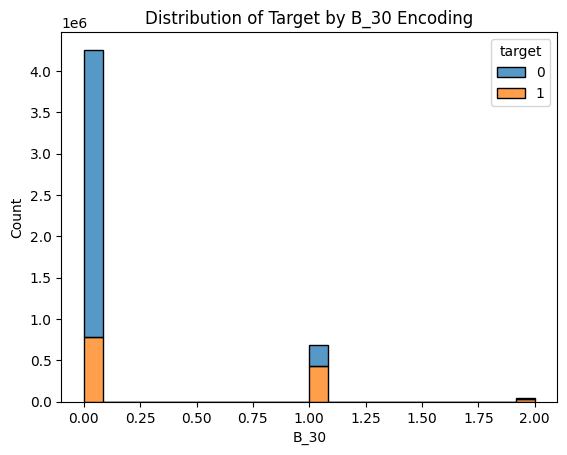

In [163]:
sns.histplot(data=df_new, x="B_30", hue="target", multiple="stack").set_title("Distribution of Target by B_30 Encoding");

B_30 buckets customers into 3 groups. It appears as though each successive bucket contains a higher proportion of accounts in default. We will likely one-hot encode B_30 when we turn our attention to feature engineering.
B_38, shown below, exhibits a similar pattern, however, there are seven buckets.

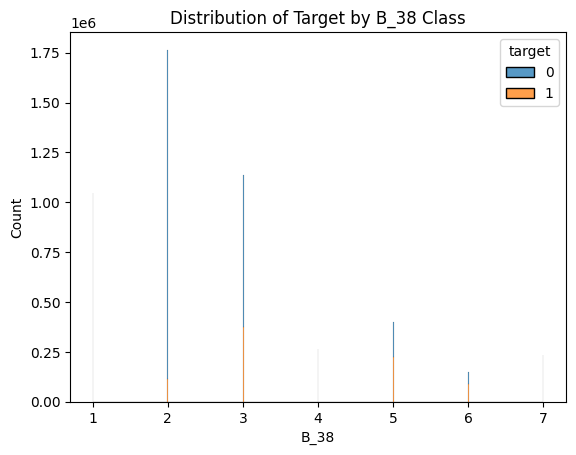

In [164]:
sns.histplot(data=df_new, x="B_38", hue="target", multiple="stack").set_title("Distribution of Target by B_38 Class");

D_114 is clearly binary with unequal distributions of defaulted and undefaulted accounts.

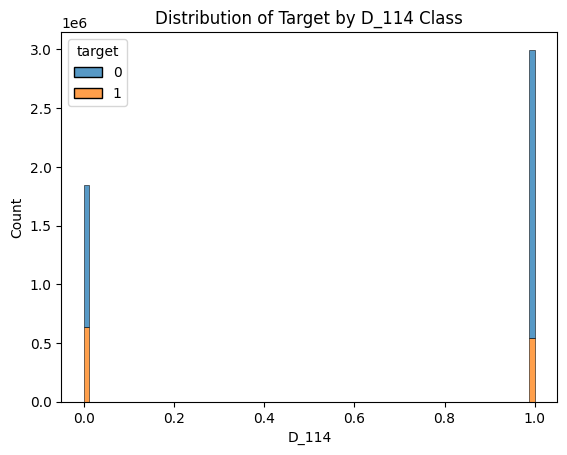

In [165]:
sns.histplot(data=df_new, x="D_114", hue="target", multiple="stack").set_title("Distribution of Target by D_114 Class");

Feature D_116 is unusual. There seems to be an attempt at binary encoding, as shown in the graph below. 

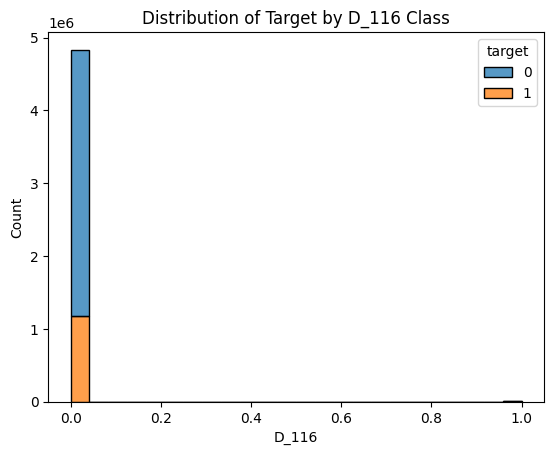

In [166]:
sns.histplot(data=df_new, x="D_116", hue="target", multiple="stack").set_title("Distribution of Target by D_116 Class");

The numerical representation of feature D_116 clarifies what the data provider intended.

In [167]:
df_new.D_116.value_counts()

0.0    4834403
1.0       6052
Name: D_116, dtype: int64

The plot of D_117 shown below bears a resemblance to B_38. The most notable feature of D_117 is that it makes use of the mysterious -1 designation.

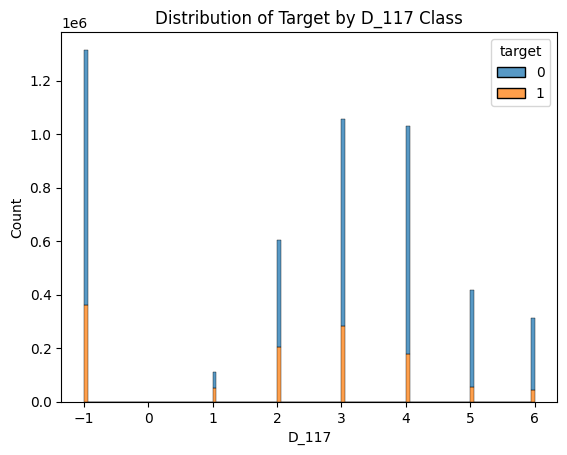

In [168]:
sns.histplot(data=df_new, x="D_117", hue="target", multiple="stack").set_title("Distribution of Target by D_117 Class");

-1 seems like a proxy for missing data, but it's impossible to be certain. Let's see if there exists a pattern within the data tied to the value -1.

In [43]:
df[df.D_117 == -1]

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,D_43,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,D_49,B_6,B_7,B_8,D_50,D_51,B_9,R_3,D_52,P_3,B_10,D_53,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,D_56,B_13,R_5,D_58,S_9,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_63,D_64,D_65,B_16,B_17,B_18,B_19,D_66,B_20,D_68,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,D_73,P_4,D_74,D_75,D_76,B_24,R_7,D_77,B_25,B_26,D_78,D_79,R_8,R_9,S_16,D_80,R_10,R_11,B_27,D_81,D_82,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,B_29,B_30,S_18,D_86,D_87,R_17,R_18,D_88,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_105,D_106,D_107,B_36,B_37,R_26,R_27,B_38,D_108,D_109,D_110,D_111,B_39,D_112,B_40,S_27,D_113,D_114,D_115,D_116,D_117,D_118,D_119,D_120,D_121,D_122,D_123,D_124,D_125,D_126,D_127,D_128,D_129,B_41,B_42,D_130,D_131,D_132,D_133,R_28,D_134,D_135,D_136,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target,Count
13,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-03-01,0.929122,0.382790,0.025782,1.002647,0.005515,0.089799,0.001479,0.005830,NaN,NaN,0.009873,0.021776,0.239459,0.070967,0.008058,0.457826,0.382562,0.059342,NaN,0.201574,0.032390,0.007684,NaN,0.334386,0.007561,0.005552,0.110471,0.619012,0.302757,NaN,0.025802,0.011677,0.003243,1.009099,0.001485,0.072583,0.026337,0.596242,0.052813,0.684371,0.036490,0.004105,0.007069,NaN,0.015918,0.230700,0.375191,0.063612,0.005119,0.281806,0.239244,CO,O,0.007912,0.174382,NaN,1.008107,0.001015,NaN,0.002688,6.0,0.175123,0.000396,0.282619,0.006760,0.006521,0.007803,0.001396,0.015735,0.002945,0.200131,0.014834,NaN,0.004637,0.000560,0.000939,NaN,0.000798,0.000963,0.222324,0.027022,0.005833,0.002569,0.000223,0.009420,NaN,0.001228,0.008212,0.000954,0.008326,0.002704,0.002767,NaN,0.000797,1.002751,0.020552,0.007203,0.002874,0.001399,0.003912,0.004593,0.004460,NaN,0.0,0.003757,0.002582,NaN,0.007083,0.004040,NaN,1,0.002157,0.009864,0.005578,0.008184,NaN,0.003199,1.006756,0.009185,0.000482,0.004166,0.007530,0.000142,0.005410,0.008460,0.001500,0.004736,0.001770,0.914921,0.135440,0.926104,0.976465,0.006042,0.001040,0.007944,0.007099,NaN,NaN,0.007600,0.005126,0.023904,NaN,1.003868,2.0,NaN,0.009713,NaN,NaN,NaN,1.008423,0.030687,NaN,0.005897,1.0,0.430118,0.0,-1.0,0.418370,0.416349,0.0,0.527146,0.292568,0.009932,0.137895,0.009582,1.0,0.008318,1.002662,0.003712,0.002124,NaN,0.002148,0.003912,NaN,0.001289,0.003198,NaN,NaN,NaN,NaN,NaN,0.003776,0.001808,0.008200,NaN,0.001061,0.000027,0.002629,0,1
14,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,2017-04-16,0.918431,0.002224,0.006806,1.008186,0.003287,0.095966,0.007831,0.000861,NaN,NaN,0.007450,0.012991,0.247009,0.026492,0.006785,0.462680,0.386114,0.083383,NaN,0.202135,0.024356,0.003301,NaN,0.672143,0.004459,0.001319,0.105637,0.591144,0.295964,NaN,0.004938,0.000887,0.006905,1.008566,0.000638,0.081383,0.019455,0.472848,0.060770,0.689035,0.041153,0.000791,0.004691,0.006782,0.005317,0.231395,0.295413,0.079257,0.003482,0.368255,0.237756,CO,O,0.006940,0.088992,NaN,1.007984,0.005159,NaN,0.008018,6.0,0.133366,0.004131,0.006044,0.003196,0.006329,0.001050,0.003582,0.009996,0.009189,0.205070,0.009042,NaN,0.009077,0.007647,0.001021,NaN,0.005710,0.001982,0.220491,0.013183,0.008285,0.002954,0.001704,0.003919,NaN,0.003258,0.008214,0.004326,0.001358,0.000442,0.000363,NaN,0.003771,1.006914,0.012105,0.001203,0.006453,0.009384,0.009396,0.000343,0.002898,NaN,0.0,0.001069,0.009929,NaN,0.007837,0.003902,NaN,1,0.008078,0.004189,0.000256,0.005347,0.000296,0.003957,1.009513,0.004663,0.000256,0.009724,0.504566,0.006717,0.005985,0.009168,0.009940,0.009356,0.004741,0.886502,0.133348,0.894015,0.976638,0.005882,0.009589,0.000881,0.007604,NaN,NaN,0.003800,0.009940,0.011567,NaN,1.001694,2.0,NaN,0.008126,NaN,NaN,NaN,1.006873,0.032634,0.317246,0.001209,1.0,0.435939,0.0,-1.0,0.426850,0.423039,1.0,0.534687,0.294283,0.007077,0.138047,0.006469,1.0,0.000664,1.004011,0.002510,0.004754,NaN,0.003031,0.000364,NaN,0.001774,0.00997

Nothing jumps out at us when looking for a pattern among those accounts marked -1, but several columns displayed missing values.

Let's briefly explore the missing values. Thresholding is a common practice when considering missing values and, specifically, deciding which columns to keep and which columns to jettison. We employ this technique below.

In [44]:
low_info_cols = []
count = []
for c in df.columns:
    if (len((df[df[c].isnull()]))/len(df) > .25):
        low_info_cols.append(c)
        count.append(len((df[df[c].isnull()]))/len(df))
print(low_info_cols)


['D_42', 'D_43', 'D_49', 'D_50', 'D_53', 'D_56', 'S_9', 'B_17', 'D_66', 'D_73', 'D_76', 'D_77', 'R_9', 'D_82', 'B_29', 'D_87', 'D_88', 'D_105', 'D_106', 'R_26', 'D_108', 'D_110', 'D_111', 'B_39', 'S_27', 'B_42', 'D_132', 'D_134', 'D_135', 'D_136', 'D_137', 'D_138', 'D_142']


In [45]:
print(f'There are {len(low_info_cols)} low-information columns, which we define as columns missing more than 25% of their values.')
print(f'Low-information columns are missing on average {round(statistics.mean(count)*100,2)}% of their values.')

There are 33 low-information columns, which we define as columns missing more than 25% of their values.
Low-information columns are missing on average 81.49% of their values.


As part of our cleaning efforts, we will drop these columns from our data frame.

In [46]:
df_new = df.drop(low_info_cols, axis=1)
test_set_new = test_set.drop(low_info_cols, axis=1)

In [47]:
print(f'Our new data frame has {df_new.shape[0]} rows and {df_new.shape[1]} columns.')

Our new data frame has 100000 rows and 159 columns.


Feature D_120 is binary, but clearly shows that the percentage of customers coded as 1 is significantly lower than those coded as zero. In fact, the proportion of observations coded as 1 appears to be almost evenly split.

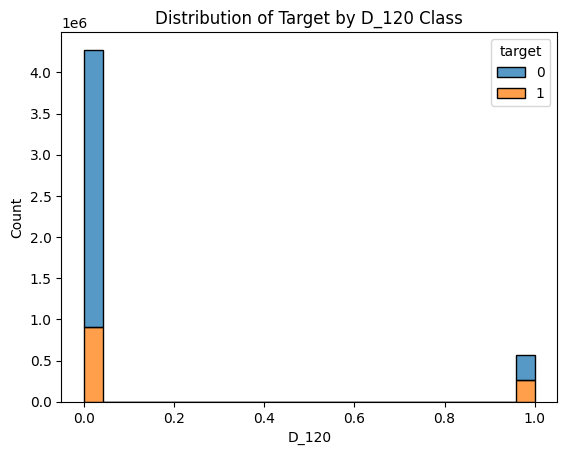

In [172]:
sns.histplot(data=df_new, x="D_120", hue="target", multiple="stack").set_title("Distribution of Target by D_120 Class");

Like D_117, D_126 makes use of the -1 code, but it remains a mystery what this code means.

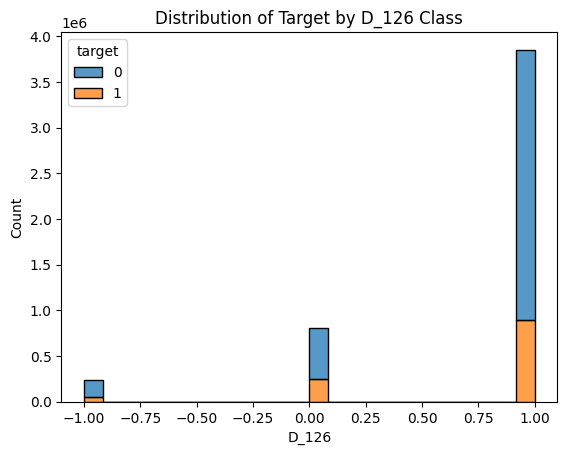

In [173]:
sns.histplot(data=df_new, x="D_126", hue="target", multiple="stack").set_title("Distribution of Target by D_126 Class");

As seen below, feature D_63 is the first categorical feature with something approximating meaningful names. Unfortunately, the meaning of the encoding remains obfuscated. We can only say that CO is, by far, the most frequent category no matter the default status.

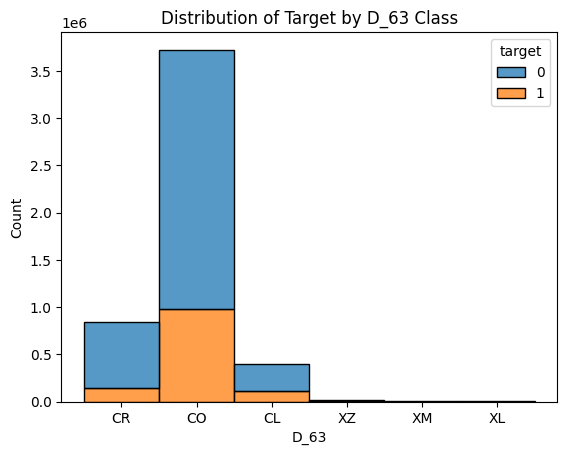

In [174]:
sns.histplot(data=df_new, x="D_63", hue="target", multiple="stack").set_title("Distribution of Target by D_63 Class");

Our assessment of D_64 is identical to D_63.

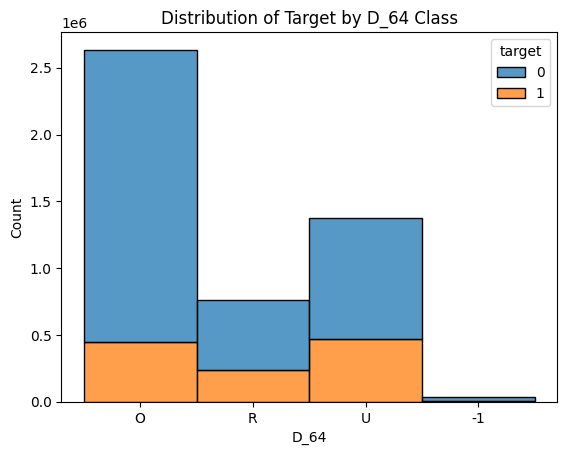

In [175]:
sns.histplot(data=df_new, x="D_64", hue="target", multiple="stack").set_title("Distribution of Target by D_64 Class");

We look at D_68 graphically and numerically. We can safely say that the percentages of each target class generally increases with the number assigned to each observation. 

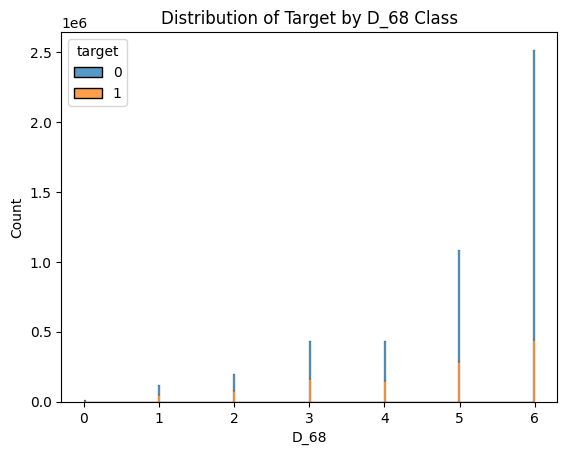

In [176]:
sns.histplot(data=df_new, x="D_68", hue="target", multiple="stack").set_title("Distribution of Target by D_68 Class");

A cross tabulation makes the trend of increasing percentages of observations in both categories easier to see.

In [177]:
pd.crosstab(df_new.D_68, df_new.target, dropna=False, margins=True, normalize=True)

target,0,1,All
D_68,,,
0.0,0.002451,0.000543,0.002995
1.0,0.014900,0.010115,0.025015
2.0,0.025131,0.016318,0.041449
3.0,0.057353,0.033726,0.091079
4.0,0.058973,0.030817,0.089791
5.0,0.166671,0.059305,0.225975
6.0,0.431822,0.091874,0.523697
All,0.750562,0.249438,1.000000


# 4.0 Data Exploration

Thus far we've taken for granted that each observation represents a separate customer, but American Express offers multiple cards and multiple cards could be tied to one individual. It would, therefore, be wise to view our data grouped by customerID.

In [48]:
print(f'There are {len(df_new["customer_ID"].unique())} unique customers in our data set versus {len(df_new)} individual observations.\nThis suggests the data contain multiple identifiers per customer.')

There are 8294 unique customers in our data set versus 100000 individual observations.
This suggests the data contain multiple identifiers per customer.


In [49]:
df_new.groupby('customer_ID')['Count'].agg('sum').describe()

count    8294.000000
mean       12.056909
std         2.584101
min         1.000000
25%        13.000000
50%        13.000000
75%        13.000000
max        13.000000
Name: Count, dtype: float64

The mean and median (marked '50%') are nearly the same. Furthermore, the same number characterizes the entire interquartile range.  This is either quite a coincidence or evidence that our data are manufactured.

As demonstrated by the graph below, a maximum of 13 observations were taken from a large number of customers, while fewer than 13 observations were collected in a minority of cases. Consequently, it seems likely the unusual summary statistics are the result of human intervention.

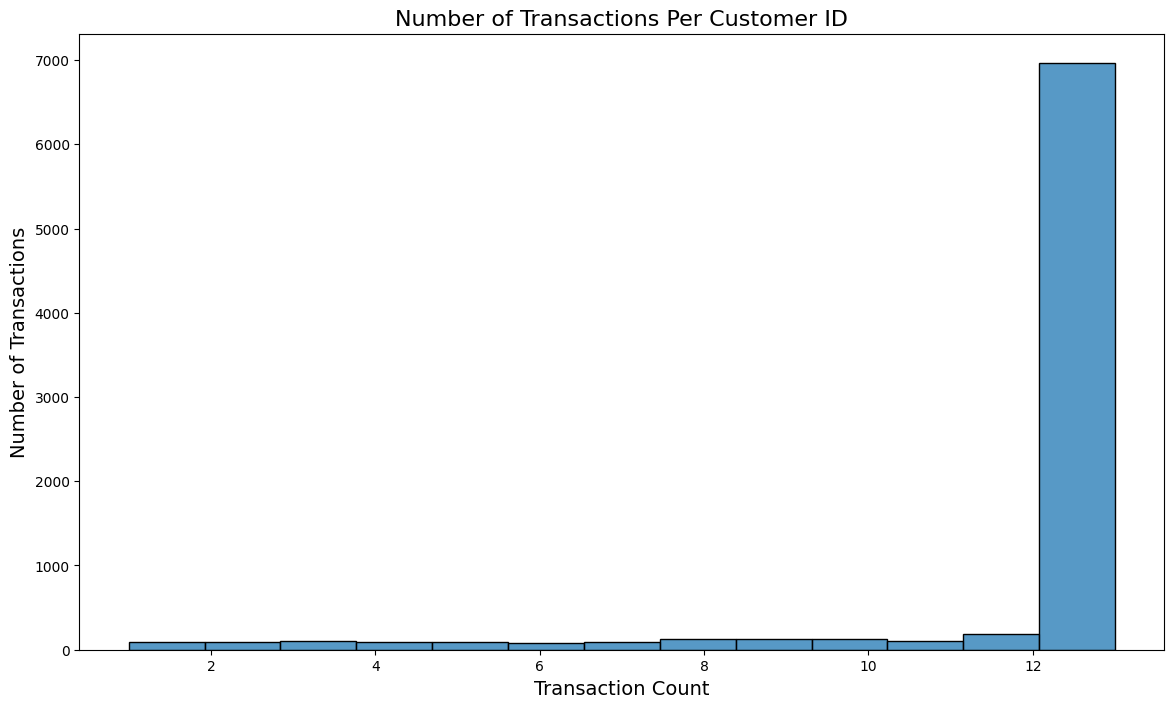

In [50]:
group_obj = df.groupby(['customer_ID'])['Count'].sum().reset_index()
plt.figure(figsize = (14,8))
sns.histplot(data = group_obj, x = 'Count', bins=13)
plt.ylabel("Number of Transactions", size=14)
plt.xlabel("Transaction Count", size=14)
plt.title("Number of Transactions Per Customer ID", size=16);

# 5.0 Feature Engineering

In this section, we extract additional meaning from the features at hand. We begin by breaking down the datetime data into month and day. 

In [51]:
df_new['month'] = df_new['S_2'].dt.month
df_new['day'] = df_new['S_2'].dt.day
test_set_new['month'] = test_set_new['S_2'].dt.month
test_set_new['day'] = test_set_new['S_2'].dt.day

As presented in the preceding section, a number of our columns are categorical, yet they contain integral values more often than not. To extract meaning from these columns we one-hot encode them. This will expand our feature space considerably, while allowing us to make the most of the data with which we have to work.

In [52]:
categorical_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']
df_cat = pd.get_dummies(df_new, columns=categorical_cols, drop_first=True)
df_cat.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,B_13,R_5,D_58,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_107,B_36,B_37,R_27,D_109,D_112,B_40,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target,Count,month,day,B_30_1.0,B_30_2.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,D_114_1.0,D_116_1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_120_1.0,D_126_0.0,D_126_1.0,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_O,D_64_R,D_64_U,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,0.000630,0.080986,0.708906,0.170600,0.006204,0.358587,0.525351,0.255736,0.063902,0.059416,0.006466,1.335856,0.008207,0.001423,0.207334,0.736463,0.096219,0.023381,0.002768,0.008322,1.001519,0.008298,0.161345,0.148266,0.922998,0.354596,0.118075,0.001882,0.158612,0.018385,0.063646,0.199617,0.308233,0.016361,0.401619,0.091071,0.007126,0.007665,0.652984,0.008520,0.004730,0.272008,0.008363,0.515222,0.002644,0.009013,0.004808,0.008342,0.119403,0.004802,0.108271,0.050882,0.007554,0.080422,0.069067,0.004327,0.007562,0.007729,0.000272,0.001576,0.004239,0.001434,0.002271,0.004061,0.007121,0.002456,0.002310,0.003532,0.008033,1.009825,0.084683,0.003820,0.007043,0.000438,0.006452,0.000830,0.005055,0.005720,0.007084,0.000198,0.008907,1,0.002537,0.005177,0.006626,0.009705,0.007782,0.002450,1.001101,0.002665,0.007479,0.006893,1.503673,1.006133,0.003569,0.008871,0.003950,0.003647,0.004950,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.670041,0.009968,0.004572,1.008949,0.004326,1.007336,0.210060,0.007871,0.238250,0.232120,0.236266,0.702280,0.434345,0.003057,0.686516,0.008740,1.003319,1.007819,1.000080,0.006805,0.002052,0.005972,0.004345,0.001535,0.002427,0.003706,0.003818,0.000569,0.000610,0.002674,0,1,3,9,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,0.002526,0.069419,0.712795,0.113239,0.006206,0.353630,0.521311,0.223329,0.065261,0.057744,0.001614,1.339794,0.008373,0.001984,0.202778,0.720886,0.099804,0.030599,0.002749,0.002482,1.009033,0.005136,0.140951,0.143530,0.919414,0.326757,0.118737,0.001610,0.148459,0.013035,0.065501,0.151387,0.265026,0.017688,0.406326,0.086805,0.002413,0.007148,0.647093,0.002238,0.003879,0.188970,0.004030,0.509048,0.004193,0.007842,0.001283,0.006524,0.140611,0.000094,0.101018,0.040469,0.004832,0.081413,0.074166,0.004203,0.005304,0.001864,0.000979,0.009896,0.007597,0.000509,0.009810,0.000127,0.005966,0.000395,0.001327,0.007773,0.000760,1.009461,0.081843,0.000347,0.007789,0.004311,0.002332,0.009469,0.003753,0.007584,0.006677,0.001142,0.005907,1,0.008427,0.008979,0.001854,0.009924,0.005987,0.002247,1.006779,0.002508,0.006827,0.002837,1.503577,1.005791,0.000571,0.000391,0.008351,0.008850,0.003180,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.668647,0.003921,0.004654,1.003205,0.008707,1.007653,0.184093,0.003444,0.247217,0.243532,0.241885,0.707017,0.430501,0.001306,0.686414,0.000755,1.008394,1.004333,1.008344,0.004407,0.001034,0.004838,0.007495,0.004931,0.003954,0.003167,0.005032,0.009576,0.005492,0.009217,0,1,4,7,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.9

In [53]:
test_set_cat = pd.get_dummies(test_set_new, columns=categorical_cols, drop_first=True)
test_set_cat.head()

,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,B_13,R_5,D_58,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_107,B_36,B_37,R_27,D_109,D_112,B_40,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,month,day,B_30_1.0,B_30_2.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,D_114_1.0,D_116_1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_120_1.0,D_126_0.0,D_126_1.0,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_R,D_64_U,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-02-19,0.631315,0.001912,0.010728,0.814497,0.007547,0.168651,0.009971,0.002347,0.007584,0.116402,0.004483,0.009517,0.005178,NaN,0.474383,0.626467,0.174591,1.250677,1.003925,0.008718,0.001013,0.103590,0.119043,NaN,-0.002919,0.002771,0.004416,1.006875,1.005069,0.002810,0.105587,0.119198,0.321676,0.114564,NaN,0.003420,0.205898,0.010182,NaN,0.027472,0.588734,0.010489,1.881856,0.051811,0.008294,0.008663,0.592103,0.009144,0.004986,0.190516,0.002675,0.409411,0.009990,NaN,0.005210,NaN,0.014684,0.004310,0.400602,1.134792,0.959531,0.217694,0.204590,0.009799,0.007748,0.006896,0.001656,0.004356,NaN,0.002008,0.002531,0.000348,0.001173,0.004170,0.004585,0.002291,0.005093,1.002944,0.133804,0.004322,NaN,0.008857,0.004144,0.009563,0.006942,0.003684,0.009909,0.008908,0.002955,1,0.008999,0.003418,0.002200,0.003781,0.002948,0.004635,1.003810,0.006653,0.007474,0.000192,NaN,0.008761,0.000835,0.004389,0.004115,0.008442,0.009575,0.981078,0.134916,0.954664,0.971086,0.006562,0.002419,NaN,NaN,NaN,0.008146,0.007970,NaN,0.005124,1.004130,0.274203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006201,NaN,NaN,0.009664,NaN,NaN,0.007082,0.005957,NaN,0.004669,NaN,NaN,0.008281,NaN,2,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
1,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-03-25,0.587042,0.005275,0.011026,0.810848,0.001817,0.241389,0.000166,0.009132,0.006646,0.134878,0.009497,0.026313,0.009029,NaN,0.473587,0.611682,0.177115,0.234169,1.009301,0.003146,0.005533,0.101239,0.120991,NaN,0.031222,0.006497,0.010003,1.005728,1.000432,0.000525,0.160562,0.121490,0.170728,0.184116,0.028347,0.007156,0.403270,0.025130,NaN,0.054790,0.622886,0.021704,2.043278,0.057567,0.002011,0.000835,0.590922,0.000165,0.001557,0.190172,0.001771,0.561424,0.008125,NaN,0.008394,0.000606,0.011945,0.002283,0.605887,0.208381,0.961667,0.216526,0.206570,0.004549,0.003098,0.003682,0.005516,0.001506,0.001013,0.006444,0.007169,0.003077,0.005880,0.004056,0.009634,0.001225,0.007319,1.003831,0.144626,0.005300,NaN,0.001477,0.002083,0.002234,0.005523,0.006410,0.007458,0.000843,0.007457,1,0.005120,0.002382,0.006557,0.001691,0.004449,0.000574,1.004629,0.004394,0.001169,0.006693,NaN,0.004318,0.008072,0.007888,0.007656,0.006347,0.006952,0.966995,0.138531,0.957019,0.975003,0.004611,0.006549,0.003031,0.008755,0.004698,0.000078,0.015463,1.007666,0.000610,1.004495,0.353639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003833,0.008782,0.005579,0.007441,0.007598,0.008074,0.007188,0.001253,0.000142,0.004940,0.009021,0.003695,0.003753,0.001460,3,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
2,00000469ba478561f23a92a868bd366de6f6527a684c9a...,2019-04-25,0.609056,0.003326,0.016390,1.004620,0.000114,0.266976,0.004196,0.004192,0.009606,0.136109,0.007020,0.060017,0.008286,NaN,0.471837,0.622228,1.417059,0.126995,1.004635,0.006082,0.000023,0.108955,0.113107,NaN,0.035532,0.003407,0.004140,0.006408,1.007979,0.004876,0.210077,0

Missing values must be dealt with in some form or fashion. We choose to replace missing values with the mean of the column in which each data point resides.

In [54]:
cols_with_missing_vals = []
for col in df_cat.columns:
    if df_cat[col].isnull().sum() > 1:
        cols_with_missing_vals.append(col)
df_cat[cols_with_missing_vals].head()

,P_2,B_2,S_3,D_41,B_3,D_44,D_45,D_46,D_48,B_6,B_8,D_52,P_3,D_54,S_7,D_55,B_13,D_59,D_61,B_15,D_62,B_16,B_19,B_20,D_69,B_22,D_70,D_72,D_74,B_25,B_26,D_78,D_79,D_80,B_27,D_81,D_83,D_84,R_20,B_33,D_89,D_91,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_107,R_27,D_109,D_112,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_128,D_129,B_41,D_130,D_131,D_133,D_139,D_140,D_141,D_143,D_144,D_145
0,0.938469,1.006838,0.124035,0.008771,0.004709,0.000630,0.708906,0.358587,0.255736,0.063902,0.006466,0.207334,0.736463,1.001519,0.161345,0.354596,0.118075,0.063646,0.308233,0.016361,0.091071,0.007665,0.008520,0.004730,0.009013,0.004808,0.008342,0.004802,0.080422,0.007729,0.000272,0.001576,0.004239,0.004061,0.002310,0.003532,0.007043,0.000830,0.007782,1.001101,0.002665,1.503673,0.894090,0.135561,0.911191,0.974539,0.001243,0.766688,1.008691,1.004587,0.670041,1.008949,0.004326,1.007336,0.007871,0.238250,0.232120,0.236266,0.702280,0.434345,0.003057,0.686516,0.008740,1.007819,1.000080,0.006805,0.002052,0.005972,0.004345,0.002427,0.003706,0.003818,0.000569,0.000610,0.002674
1,0.936665,1.000653,0.126750,0.000798,0.002714,0.002526,0.712795,0.353630,0.223329,0.065261,0.001614,0.202778,0.720886,1.009033,0.140951,0.326757,0.118737,0.065501,0.265026,0.017688,0.086805,0.007148,0.002238,0.003879,0.007842,0.001283,0.006524,0.000094,0.081413,0.001864,0.000979,0.009896,0.007597,0.000127,0.001327,0.007773,0.007789,0.009469,0.005987,1.006779,0.002508,1.503577,0.902135,0.136333,0.919876,0.975624,0.004561,0.786007,1.000084,1.004118,0.668647,1.003205,0.008707,1.007653,0.003444,0.247217,0.243532,0.241885,0.707017,0.430501,0.001306,0.686414,0.000755,1.004333,1.008344,0.004407,0.001034,0.004838,0.007495,0.003954,0.003167,0.005032,0.009576,0.005492,0.009217
2,0.954180,1.009672,0.123977,0.007598,0.009423,0.007605,0.720884,0.334650,0.189424,0.066982,0.005126,0.206629,0.738044,1.009184,0.112229,0.304124,0.114534,0.070607,0.212165,0.063955,0.094001,0.003636,0.000408,0.004578,0.006025,0.009393,0.002615,0.007152,0.078891,0.005419,0.006149,0.009629,0.003094,0.000954,0.007624,0.008811,0.004093,0.002325,0.007291,1.001014,0.009634,1.503359,0.939654,0.134938,0.958699,0.974067,0.011736,0.806840,1.003014,1.009285,0.670901,1.000754,0.004092,1.004312,0.003269,0.239867,0.240768,0.239710,0.704843,0.434409,0.003954,0.690101,0.009617,1.007831,1.006878,0.003221,0.005681,0.005497,0.009227,0.003269,0.007329,0.000427,0.003429,0.006986,0.002603
3,0.960384,1.002700,0.117169,0.000685,0.005531,0.006406,0.723997,0.323271,0.135586,0.083720,0.001418,0.208214,0.741813,1.007456,0.102838,0.275055,0.120740,0.065926,0.204300,0.022732,0.094854,0.005896,0.005897,0.005207,0.005271,0.004554,0.002052,0.005364,0.077490,0.000646,0.009193,0.008568,0.003895,0.005665,0.000034,0.004652,0.008817,0.005924,0.009977,1.002775,0.007791,1.503701,0.913205,0.140058,0.926341,0.975499,0.007571,0.808214,1.001517,1.004514,0.672620,1.005338,0.009703,1.002538,0.000053,0.240910,0.239400,0.240727,0.711546,0.436903,0.005135,0.687779,0.004649,1.003460,1.007573,0.007703,0.007108,0.008261,0.007206,0.006117,0.004516,0.003200,0.008419,0.006527,0.009600
4,0.947248,1.000727,0.117325,0.004653,0.009312,0.007731,0.720619,0.231009,NaN,0.075900,0.001199,0.205468,0.691986,1.003738,0.094311,0.231110,0.095178,0.063697,0.175655,0.031171,0.093915,0.001714,0.007773,0.005851,0.000152,0.000104,0.001419,0.007972,0.076561,0.001833,0.005738,0.003289,0.002608,0.004465,0.002109,0.001141,0.001845,0.005516,0.004105,1.006536,0.005158,1.509905,0.921026,0.131620,0.933479,0.978027,0.018200,0.822281,1.006125,1.005735,0.673869,1.003175,0.009120,1.000130,0.008724,0.247939,0.244199,0.242325,0.705343,0.437433,0.002849,0.688774,0.000097,1.005053,1.008132,0.009823,0.009680,0.004848,0.006312,0.003671,0.004946,0.008889,0.001670,0.008126,0.009827


In [55]:
for colm in cols_with_missing_vals:
    mean=df_cat[colm].mean()
    df_cat[colm].fillna(value=mean, inplace=True)
print('Missing values filled with column mean.')

Missing values filled with column mean.


Below, we apply the same remedy for missing values to our test set as above.

In [58]:
test_cols_with_missing_vals = []
for col in test_set_cat.columns:
    if test_set_cat[col].isnull().sum() > 1:
        test_cols_with_missing_vals.append(col)
test_set_cat[cols_with_missing_vals].head()

,P_2,B_2,S_3,D_41,B_3,D_44,D_45,D_46,D_48,B_6,B_8,D_52,P_3,D_54,S_7,D_55,B_13,D_59,D_61,B_15,D_62,B_16,B_19,B_20,D_69,B_22,D_70,D_72,D_74,B_25,B_26,D_78,D_79,D_80,B_27,D_81,D_83,D_84,R_20,B_33,D_89,D_91,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_107,R_27,D_109,D_112,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_128,D_129,B_41,D_130,D_131,D_133,D_139,D_140,D_141,D_143,D_144,D_145
0,0.631315,0.814497,0.168651,0.009971,0.002347,0.007584,0.004483,NaN,0.626467,0.174591,1.003925,0.119043,NaN,1.005069,0.105587,0.114564,NaN,NaN,0.588734,0.010489,0.051811,0.008663,0.009144,0.004986,NaN,0.005210,NaN,0.004310,0.217694,0.006896,0.001656,0.004356,NaN,0.000348,0.004585,0.002291,NaN,0.009563,0.002948,1.003810,0.006653,NaN,0.981078,0.134916,0.954664,0.971086,0.006562,0.002419,NaN,NaN,NaN,NaN,0.005124,1.004130,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009664,NaN,NaN,0.007082,NaN,0.004669,NaN,NaN,0.008281,NaN
1,0.587042,0.810848,0.241389,0.000166,0.009132,0.006646,0.009497,NaN,0.611682,0.177115,1.009301,0.120991,NaN,1.000432,0.160562,0.184116,0.028347,NaN,0.622886,0.021704,0.057567,0.000835,0.000165,0.001557,NaN,0.008394,0.000606,0.002283,0.216526,0.003682,0.005516,0.001506,0.001013,0.003077,0.009634,0.001225,NaN,0.002234,0.004449,1.004629,0.004394,NaN,0.966995,0.138531,0.957019,0.975003,0.004611,0.006549,0.003031,0.008755,0.004698,1.007666,0.000610,1.004495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008782,0.005579,0.007441,0.007598,0.008074,0.007188,0.000142,0.004940,0.009021,0.003695,0.003753,0.001460
2,0.609056,1.004620,0.266976,0.004196,0.004192,0.009606,0.007020,NaN,0.622228,1.417059,1.004635,0.113107,NaN,1.007979,0.210077,0.253969,0.033726,0.423664,0.617996,0.039339,0.050673,0.006182,0.006097,0.002339,NaN,0.002630,0.001675,0.002481,0.223477,0.002389,0.000776,0.007588,0.008679,0.000671,0.006634,0.009232,NaN,0.002693,0.002201,1.007063,0.004019,NaN,0.970504,0.136436,0.964148,0.978581,0.005550,0.006819,0.002500,0.008872,0.004696,1.005097,0.006811,1.003939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005602,0.009336,0.009595,0.003608,0.009865,0.008436,0.000074,0.002114,0.004656,0.003155,0.002156,0.006482
3,0.614911,0.816549,0.188947,0.004123,0.015325,0.007820,0.008946,NaN,0.615620,0.044620,1.009093,0.120276,NaN,1.003715,0.193704,0.305662,0.040765,0.400214,0.614086,0.025483,0.015384,0.009910,0.002537,0.006877,NaN,0.004402,0.000454,0.001988,0.216830,0.004244,0.006314,0.004431,0.007889,0.007267,0.006116,0.009567,NaN,0.004952,0.000277,1.009508,0.003135,NaN,0.926058,0.131422,0.929261,0.976669,0.001566,0.009241,0.009274,0.008570,0.003453,1.005593,0.006936,1.002883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008690,0.006479,0.006602,0.006133,0.005897,0.002422,0.004743,0.006392,0.002890,0.006044,0.005206,0.007855
4,0.591673,0.810456,0.180035,0.000731,0.011281,0.009959,0.008514,0.442145,0.591795,0.039586,1.006634,0.115423,0.597524,1.005363,0.202131,0.350231,0.063157,0.401725,0.592988,0.016975,0.020399,0.000131,0.001112,0.007519,0.007157,0.000384,0.005929,0.000674,0.214919,0.000604,0.005901,0.006243,0.006990,0.009457,0.003339,0.005440,0.001843,0.009974,0.007483,1.001869,0.004443,NaN,0.914256,0.139606,0.904863,0.975395,0.002411,0.009546,0.003093,0.000221,0.003509,1.009070,0.001480,1.003670,0.005624,0.24982,0.243366,0.245074,0.198171,0.149127,0.003232,0.009485,0.007616,0.005304,0.002027,0.008995,0.006975,0.005312,0.000302,0.008133,0.004329,0.008384,0.001008,0.007421,0.009471


In [59]:
for colmn in test_cols_with_missing_vals:
    mean=test_set_cat[colmn].mean()
    test_set_cat[colmn].fillna(value=mean, inplace=True)
print('Missing values in test set filled with column means.')

Missing values in test set filled with column means.


Classification problems are often typified by an imbalance between the positive and negative classes. Generally, one can expect fewer positive cases than negative cases. 

Recall that a '1' in our target column represents default. This is our positive class despite being a decidedly negative event. Our negative case, represented by a '0' in the target column, indicates a customer account is up-to-date. Below, we explore the distribution between the positive and negative classes. 

In [60]:
class_distribution = df_new.target.value_counts()
print(f'Approximately {round(class_distribution[1]/class_distribution[0],2)*100}% of observations are in the positive (delinquent) class.')
class_distribution

Approximately 34.0% of observations are in the positive (delinquent) class.


0    74613
1    25387
Name: target, dtype: int64

A class imbalance clearly exists. In the next section, we demonstrate how pyCaret uses SMOTE to address this issue.

# 5.0 Modeling and Model Testing

PyCaret is designed to automatically do everything we just accomplished manually. This begs the question: Did we just waste our time? The answer is a firm, "no." Using black boxes is horrible practice. Consequently, we've limited our use of PyCaret, restricting it to the modeling phase of our study. PyCaret's modeling capabilities are built on familiar scikit-learn technology. Hence, there are no black boxes, as we have used scikit-learn often in the past.

Though we have a test set, PyCaret splits the data in its own way for training and testing. This is what occurs in the following cell. More importantly, it allows us to use the training set supplied by the Kaggle site as yet another test set. This is a marvelous turn of events because, typically, prototyping involves only one test set, which can cause data leakage issues if the test set is used more than once. Below, we split the data using PyCaret.

In [63]:
y = df_cat['target']
X_pycaret = df_cat.copy(deep=True)
X_pycaret = X_pycaret.drop(['Count', 'customer_ID'], axis=1)
data = X_pycaret.sample(frac=0.70, random_state=144).reset_index(drop=True)
data_unseen = X_pycaret.drop(data.index).reset_index(drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (70000, 182)
Unseen Data For Predictions: (30000, 182)


In [64]:
data.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,B_13,R_5,D_58,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_107,B_36,B_37,R_27,D_109,D_112,B_40,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target,month,day,B_30_1.0,B_30_2.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,D_114_1.0,D_116_1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_120_1.0,D_126_0.0,D_126_1.0,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_O,D_64_R,D_64_U,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0
0,2017-03-13,0.897923,0.000585,0.028842,1.000561,0.007382,0.145290,0.004386,0.008846,0.001200,0.028839,0.371686,0.117398,0.006254,0.473235,0.348115,0.387452,0.198525,0.025706,0.009769,0.672505,0.006323,0.006045,0.148641,0.624886,0.299538,0.113653,0.015162,0.004425,1.008144,0.003391,0.105334,0.130822,0.487746,0.302685,0.106519,0.000415,0.008283,0.063885,0.437936,1.002405,0.435253,0.074860,0.242900,0.189365,0.008826,0.009072,1.009341,0.005559,0.006926,0.235761,0.000707,0.428033,0.004150,0.004488,0.008161,0.007874,0.745712,0.002194,0.303842,0.015615,0.009405,0.009150,0.005270,0.005496,0.007083,0.005548,0.009946,0.006855,0.006065,0.003247,0.006311,0.004519,0.008702,0.005418,0.007937,0.009007,0.006449,1.008672,0.031124,0.007139,0.000616,0.000233,0.002434,0.002979,0.002378,0.005497,0.003161,0.006927,0.007542,1,0.000375,0.006756,0.003243,0.003777,0.004174,0.007435,1.007634,0.003765,0.007057,0.005569,0.001485,1.000643,0.004770,1.006639,0.007359,0.003011,0.002505,0.948684,0.131571,0.967842,0.970664,0.002959,0.199530,1.007736,0.961609,0.336940,0.006716,0.027328,1.005960,0.004056,1.005315,0.003159,0.002665,0.143658,0.322648,0.208492,0.598564,0.722680,0.007554,0.503161,0.000481,1.007475,1.003516,1.003490,0.008917,0.006817,0.008813,0.008929,0.009801,0.004716,0.003748,0.002341,0.009554,0.001006,0.009201,0,3,13,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0
1,2017-05-05,0.810232,0.001973,0.011669,1.005728,0.007285,0.178322,0.006122,0.011699,0.001134,0.006670,0.592205,0.011149,0.008002,0.395576,0.523531,0.387452,0.066082,0.005831,0.005322,0.008248,0.001221,0.103713,0.048837,0.695501,0.299975,0.006552,0.007116,0.006712,1.000641,0.004859,0.106775,0.023188,0.607683,0.133092,0.032111,0.008865,0.007244,0.008706,0.068350,1.009426,0.435253,0.004980,0.121697,0.189365,0.000726,0.334061,1.004208,0.002697,0.004558,0.191840,0.007431,0.006040,0.009577,0.002531,0.006119,0.008322,0.010944,0.006104,-0.090698,0.006026,0.007779,0.006768,0.000474,0.000759,0.000380,0.001803,0.007497,0.008970,0.007782,0.005526,0.000436,0.003839,0.003690,0.008954,0.001072,0.003014,0.007714,1.000369,0.003498,0.004650,0.009707,0.001274,0.004829,0.007318,0.002400,0.004405,0.001610,0.002078,0.005661,1,0.002724,0.002979,0.006341,0.003136,0.008172,0.006221,1.000664,0.008580,0.008664,0.008779,0.005174,0.001958,0.009031,0.009076,0.003927,0.008936,0.003102,0.896223,0.140083,0.919760,0.972397,0.006856,0.369390,1.007687,0.958374,0.335323,0.004983,0.009261,1.002321,0.005418,1.005046,0.004667,0.200931,0.024448,0.003499,0.004843,0.759332,0.435491,0.002623,0.548746,1.008202,0.003594,1.000750,0.000487,0.005195,0.002049,0.009502,0.003606,0.008917,0.007143,0.009974,0.008777,0.001110,0.002675,0.009662,0,5,5,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,2017-12-04,0.671226,0.002897,0.018535,1.001146,0.002129,0.161875,0.008754,0.006287,0.000107,0.008255,0.067040,0.078537,0.001318,0.487367,0.075591,0.356188,0.072300,0.018972,1.006612,0.

In [65]:
data_unseen.head()

,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_44,B_4,D_45,B_5,R_2,D_46,D_47,D_48,B_6,B_7,B_8,D_51,B_9,R_3,D_52,P_3,B_10,S_5,B_11,S_6,D_54,R_4,S_7,B_12,S_8,D_55,B_13,R_5,D_58,B_14,D_59,D_60,D_61,B_15,S_11,D_62,D_65,B_16,B_18,B_19,B_20,S_12,R_6,S_13,B_21,D_69,B_22,D_70,D_71,D_72,S_15,B_23,P_4,D_74,D_75,B_24,R_7,B_25,B_26,D_78,D_79,R_8,S_16,D_80,R_10,R_11,B_27,D_81,S_17,R_12,B_28,R_13,D_83,R_14,R_15,D_84,R_16,S_18,D_86,R_17,R_18,B_31,S_19,R_19,B_32,S_20,R_20,R_21,B_33,D_89,R_22,R_23,D_91,D_92,D_93,D_94,R_24,R_25,D_96,S_22,S_23,S_24,S_25,S_26,D_102,D_103,D_104,D_107,B_36,B_37,R_27,D_109,D_112,B_40,D_113,D_115,D_118,D_119,D_121,D_122,D_123,D_124,D_125,D_127,D_128,D_129,B_41,D_130,D_131,D_133,R_28,D_139,D_140,D_141,D_143,D_144,D_145,target,month,day,B_30_1.0,B_30_2.0,B_38_2.0,B_38_3.0,B_38_4.0,B_38_5.0,B_38_6.0,B_38_7.0,D_114_1.0,D_116_1.0,D_117_1.0,D_117_2.0,D_117_3.0,D_117_4.0,D_117_5.0,D_117_6.0,D_120_1.0,D_126_0.0,D_126_1.0,D_63_CO,D_63_CR,D_63_XL,D_63_XM,D_63_XZ,D_64_O,D_64_R,D_64_U,D_68_1.0,D_68_2.0,D_68_3.0,D_68_4.0,D_68_5.0,D_68_6.0
0,2018-01-02,0.963537,0.681581,0.045345,1.003465,0.004910,0.092361,0.001244,0.009534,0.008116,0.014066,0.302358,0.010821,0.001286,0.473235,0.275166,0.387452,0.225523,0.044138,0.001043,0.675884,0.034891,0.005942,0.199559,0.683073,0.302125,0.006083,0.031934,0.008436,1.000233,0.005367,0.050379,0.043116,0.484452,0.302685,0.024526,0.002171,0.000930,0.050790,0.629863,1.006508,0.435253,0.003116,0.563003,0.189365,0.000611,0.421789,1.000414,0.184107,0.002173,0.192487,0.003580,0.630540,0.001785,0.007330,0.001170,0.001675,0.145804,0.006984,0.304056,0.032229,0.004670,0.001956,0.004179,0.003476,0.002312,0.083056,0.006761,0.007806,0.008111,0.002449,0.006157,0.001590,0.009156,0.003000,0.003359,0.006082,0.006315,1.008445,0.024927,0.003326,0.007741,0.000120,0.004393,0.004028,0.003882,0.006388,0.001872,0.007652,0.003831,1,0.002841,0.002335,0.006868,0.004947,0.001863,0.007286,1.001329,0.002377,0.002595,0.008423,0.503590,0.002345,0.006546,0.006109,0.008876,0.004583,0.007619,0.943007,0.135944,0.950313,0.974487,0.005774,0.152862,1.008030,0.957771,0.341544,0.004959,0.050042,1.002395,0.009466,1.001915,0.001652,0.004459,0.417370,0.405365,0.410262,0.567487,0.866316,0.001543,0.318229,0.002165,1.004654,1.008190,1.003964,0.006385,0.001155,0.008736,0.009918,0.003526,0.002260,0.007905,0.009719,0.005948,0.003410,0.008214,0,1,2,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1
1,2018-02-05,0.944978,0.003979,0.016652,1.007144,0.004047,0.135255,0.002136,0.014089,0.001871,0.004523,0.299584,0.327840,0.008243,0.473235,0.277390,0.387452,0.331235,0.008487,0.005799,0.340394,0.004143,0.007097,0.200671,0.665267,0.301983,0.000057,0.007818,0.004140,1.009757,0.008791,0.102934,0.049249,0.412182,0.302685,0.134067,0.005749,0.003268,0.010985,0.650431,1.004134,0.435253,0.006438,0.521072,0.189365,0.009204,0.417400,1.001644,0.095004,0.001322,0.190552,0.003164,0.282232,0.005734,0.009176,0.007916,0.009973,0.200813,0.000744,0.301928,0.009902,0.001480,0.000635,0.003666,0.001124,0.000945,0.015629,0.005930,0.001424,0.001249,0.007049,0.003553,0.009680,0.002913,0.001101,0.007127,0.005061,0.003148,1.000861,0.009819,0.003560,0.006021,0.000702,0.008266,0.004626,0.006209,0.003727,0.009402,0.003617,0.009781,1,0.008730,0.009396,0.009090,0.009331,0.001499,0.006602,1.006180,0.006854,0.002863,0.004111,0.004538,0.007113,0.003110,0.003268,0.005448,0.008200,0.008158,0.884451,0.132087,0.921188,0.975029,0.310562,0.154876,1.003737,0.956373,0.337863,0.008831,0.009252,1.009133,0.004973,1.001468,0.007387,0.009064,0.409390,0.405073,0.404024,0.570416,0.867131,0.002353,0.327264,0.003043,1.008369,1.003663,1.004182,0.005140,0.003534,0.003930,0.006494,0.004581,0.008651,0.002301,0.005464,0.002827,0.000394,0.004806,0,2,5,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1
2,2018-03-22,0.932406,0.384620,0.037476,1.005431,0.008427,0.142738,0.009979,0.003312,0.121686,0.016507,0.302592,0.031271,0.006451,0.473235,0.285050,0.387452,0.327057,0.031814,0.003223,0.34

This is one of our more exciting lines of code. Here, we setup PyCaret to use our training data and target to try several models that we believe could assist us in addressing our research question. PyCaret will also correct for multicollinearity (+90% correlation) and perform k-fold crossvalidation on our models where k = 3. Typically, we cross-validate on the interval [5, 10], however, we are resource constrained. We use SMOTE to correct the class imbalance given additional resources.

In [69]:
import lightgbm #this is specific to macs
from pycaret.classification import *
s = setup(data = data, target = 'target', remove_multicollinearity=True, fold=3, fix_imbalance = True, session_id=1024)

,Description,Value
0,Session id,1024
1,Target,target
2,Target type,Binary
3,Original data shape,"(70000, 182)"
4,Transformed data shape,"(94040, 169)"
5,Transformed train set shape,"(73040, 169)"
6,Transformed test set shape,"(21000, 169)"
7,Numeric features,180
8,Date features,1
9,Preprocess,True


We now search for the best model, limiting the number of models considered to the most effective, as well as a `dummy` baseline model.

In [70]:
best = compare_models(sort="Recall", include = ['lightgbm', 'gbc', 'dummy'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8676,0.9335,0.8134,0.7095,0.7579,0.6674,0.6703,60.7967
lightgbm,Light Gradient Boosting Machine,0.8926,0.9539,0.8107,0.7772,0.7936,0.7210,0.7213,4.1033
dummy,Dummy Classifier,0.7453,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6633


Processing:   0%|          | 0/17 [00:00<?, ?it/s]

Let's take a look at the winning model: Light Gradient Boosting Machine. We'll use 5-fold cross-validation. For those wondering why we did not choose gbc even though it optimized recall best, the answer should be fairly obvious. The difference in recall for lightgbm vs. gbc is small, and lightgbm is the winner on all other metrics.

The model's statistics look even better under 5-fold cross validation.

In [71]:
lgbm = create_model('lightgbm', cross_validation=True, fold=5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8978,0.9564,0.8301,0.7819,0.8053,0.7360,0.7367
1,0.8976,0.9588,0.8161,0.7889,0.8023,0.7332,0.7334
2,0.8939,0.9545,0.8129,0.7798,0.7960,0.7243,0.7246
3,0.8880,0.9517,0.8173,0.7606,0.7879,0.7119,0.7128
4,0.8912,0.9539,0.8181,0.7694,0.7930,0.7193,0.7200
Mean,0.8937,0.9551,0.8189,0.7761,0.7969,0.7250,0.7255
Std,0.0038,0.0024,0.0059,0.0100,0.0063,0.0089,0.0087


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

We should tune our model to optimize recall. We will use 5-Fold cross validation. The error messages are discussed at length on github and can be safely ignored.

In [75]:
tuned_lgbm = tune_model(lgbm, optimize='Recall', fold=5);

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8652,0.9346,0.8750,0.6840,0.7678,0.6748,0.6850
1,0.8655,0.9394,0.8650,0.6876,0.7661,0.6735,0.6822
2,0.8638,0.9355,0.8646,0.6840,0.7638,0.6699,0.6789
3,0.8530,0.9268,0.8614,0.6626,0.7490,0.6475,0.6587
4,0.8595,0.9314,0.8654,0.6748,0.7583,0.6614,0.6715
Mean,0.8614,0.9335,0.8663,0.6786,0.7610,0.6654,0.6753
Std,0.0047,0.0042,0.0046,0.0091,0.0068,0.0101,0.0094


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM

We can view our tuned lgbm model below. 

In [76]:
tuned_lgbm

LGBMClassifier(bagging_fraction=0.7, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=1e-06, max_depth=-1,
               min_child_samples=61, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=200, n_jobs=-1, num_leaves=256, objective=None,
               random_state=1024, reg_alpha=5, reg_lambda=0.1, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Our ROC score tells us, among other things, our model is significantly better than a coin toss.

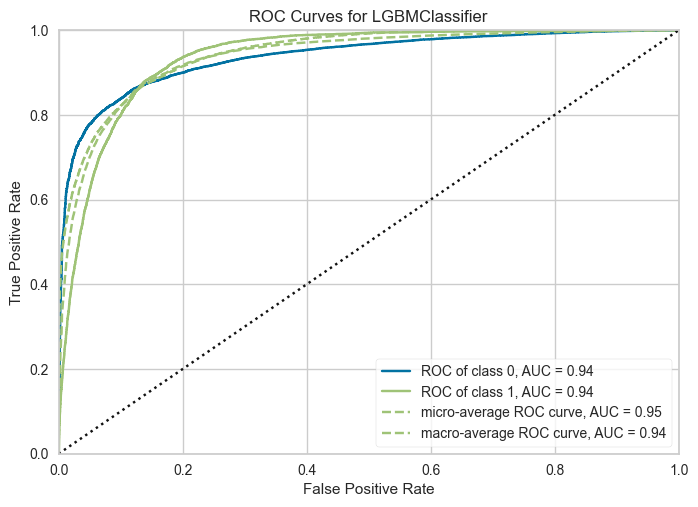

In [77]:
plot_model(tuned_lgbm)

In our humble opinion, the real test of the model is its performance on the confusion matrix.

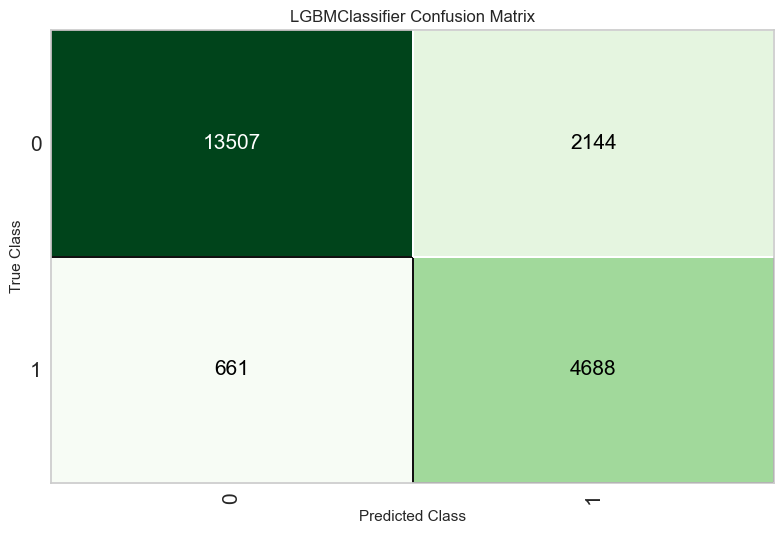

In [78]:
plot_model(tuned_lgbm, plot = 'confusion_matrix')

In general, we like what we see. The accuracy is high, while false positives outnumber false negatives. This is a plus because all accounts marked positive will be reviewed, and skewing classification towards the positive class (optimizing recall) will ensure that accounts in, or approaching default, are rarely missed.

Below, we see that not all features are equally important in our model. In fact, only 10 of the original 191 are considered important when using the tuned model.

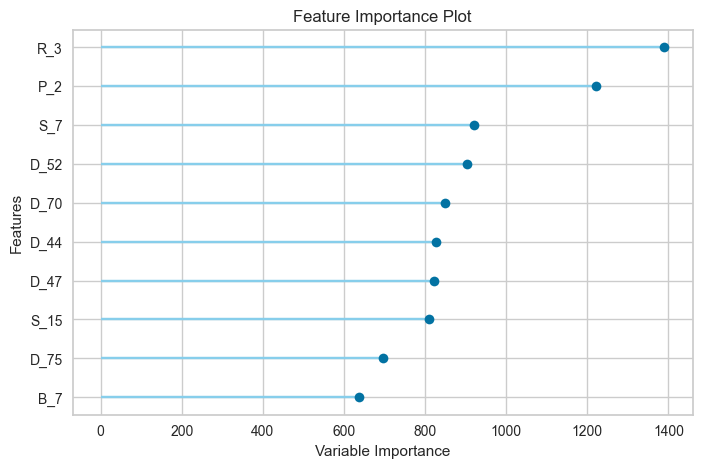

In [80]:
plot_model(tuned_lgbm, plot='feature')

In [92]:
# Make predictions on the test set
prediction_matrix = predict_model(tuned_lgbm)
prediction_matrix
pd.crosstab(prediction_matrix.target, prediction_matrix.prediction_label)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8664,0.9370,0.8764,0.6862,0.7697,0.6776,0.6877


prediction_label,0,1
target,,
0,13507,2144
1,661,4688


Our results on the test set look promising. Below, we view the model we would use if copying and pasting it into scikit-learn.

In [93]:
finalize_model(tuned_lgbm)

Pipeline(memory=FastMemory(location=/var/folders/y_/hz1vxjzs1cs561dcc_gdd8k00000gn/T/joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['S_2'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['P_2', 'D_39', 'B_1', 'B_2', 'R_1',
                                             'S_3', 'D_41'...
                                colsample_bytree=1.0, feature_fraction=0.5,
                                importance_type='split', learning_rate=1e-06,
                                max_depth=-1, min_child_samples=61,
                                min_child_weight=0.001, min_split_gai

Here, we save the model for future use.

In [94]:
# Save the model
save_model(tuned_lgbm, 'model_2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/var/folders/y_/hz1vxjzs1cs561dcc_gdd8k00000gn/T/joblib),
          steps=[('date_feature_extractor',
                  TransformerWrapper(exclude=None, include=['S_2'],
                                     transformer=ExtractDateTimeFeatures(features=['day',
                                                                                   'month',
                                                                                   'year']))),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['P_2', 'D_39', 'B_1', 'B_2', 'R_1',
                                              'S_3', 'D_41'...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=1e-06,
                                 max_depth=-1, min_child_samples=61,
                                 min_child_weight=0.001,